In [1]:
import os
import json
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from monai import data
from monai import transforms
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
    CropForegroundd, 
    SpatialPad
)
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd, SpatialPadd, Compose
)
from monai.data import Dataset, DataLoader

from monai.inferers import sliding_window_inference
import torch
import torch.nn as nn

In [3]:
roi = (64, 64, 64)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=24,
    use_checkpoint=True,
).to(device)

In [4]:
case_num = "01619"
data_dir = "./TrainingData"
test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

def calculate_pad_size(original_size):
    return [(((s + 31) // 32) * 32) - s for s in original_size]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.SpatialPadd(
            keys=["image", "label"],
            spatial_size=(256, 256, 160) 
        ),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [5]:
current_dir = os.getcwd()
checkpoint = torch.load(os.path.join(current_dir, "final_model.pt"), weights_only=False)
model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)

In [6]:
corrected_data = []
for item in test_loader.dataset.data:
    item["image"] = [img_path.replace("TrainingData\\TrainingData", "TrainingData") for img_path in item["image"]]
    corrected_data.append(item)

test_loader.dataset.data = corrected_data

In [7]:
with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

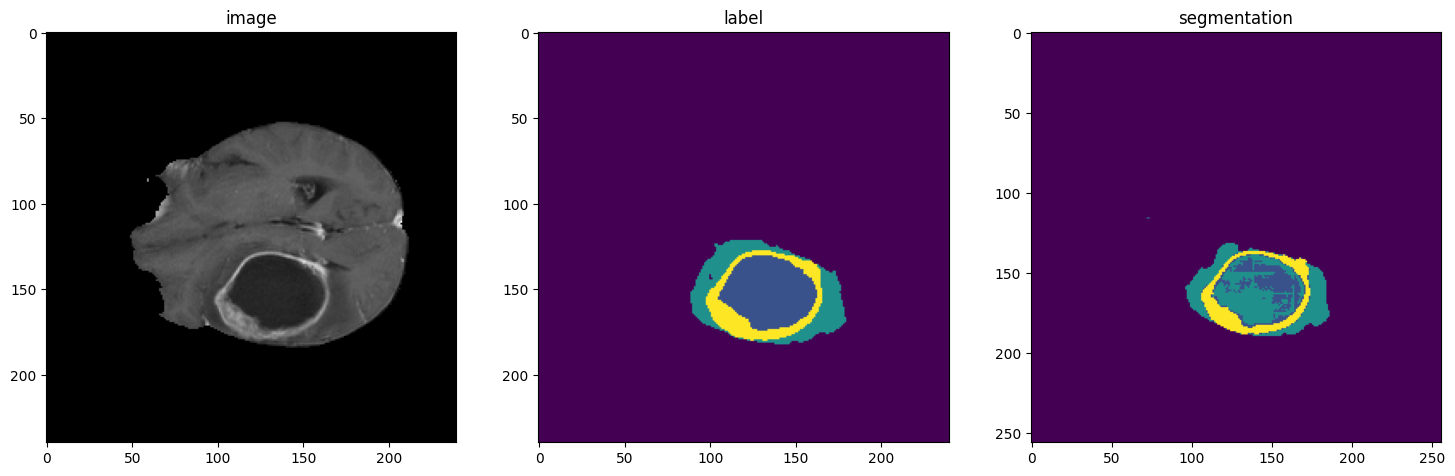

In [8]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

switch to cpu 

In [9]:
roi = (64, 64, 64)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=24,
    use_checkpoint=True,
).to(device)

In [10]:
# Define preprocessing transforms
test_transform = Compose([
    LoadImaged(keys=["image"]),  # Load NIfTI images
    EnsureChannelFirstd(keys=["image"]),  # Ensure correct channel order
    ScaleIntensityd(keys=["image"]),  # Normalize intensity
    SpatialPadd(keys=["image"], spatial_size=(256, 256, 160)),  # Pad to required shape
])

# Create dataset & dataloader
test_ds = Dataset(data=test_files, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Load one batch of image data
test_data = next(iter(test_loader))  # Get the first batch
image = test_data["image"].to(device)  # Move to CPU

In [12]:
attentions = []

def hook_fn(module, input, output):
    attentions.append(output)  # Store attention maps

# Register hook to all attention layers
for layer in model.swinViT.layers1[0].blocks:
    layer.attn.register_forward_hook(hook_fn)

# Run inference
with torch.no_grad():
    output = model(image)

# attentions now contain the attention maps


In [13]:
print(attentions[0].shape)

torch.Size([4332, 343, 24])


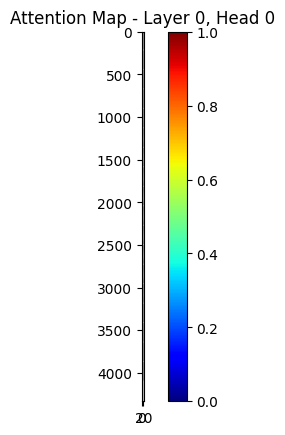

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Select a specific attention layer and head (e.g., first layer, first head)
attn_layer = 0
attn_head = 0

# Extract attention from that layer and head
attn_map = attentions[attn_layer][:, attn_head, :].cpu().numpy()  # Convert to NumPy

# Normalize for visualization
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

# Plot the attention heatmap
plt.imshow(attn_map, cmap="jet")
plt.colorbar()
plt.title(f"Attention Map - Layer {attn_layer}, Head {attn_head}")
plt.show()


In [23]:
print(f"Last attention shape: {last_attention.shape}")  # Should be (4332, 343, 24)
print(f"Num heads: {num_heads}")  # How many heads are there?
print(f"Patch dimension assumption: {patch_dim}x{patch_dim}")  # Is it correct?

# Select a random attention map to inspect
sample_attn_map = last_attention[:, :, 0]  # Choose the first head
print(f"Sample attention map shape (before processing): {sample_attn_map.shape}")  
# Expected: (4332, 343)


Last attention shape: (4332, 343, 24)
Num heads: 16
Patch dimension assumption: 19x19
Sample attention map shape (before processing): (4332, 343)


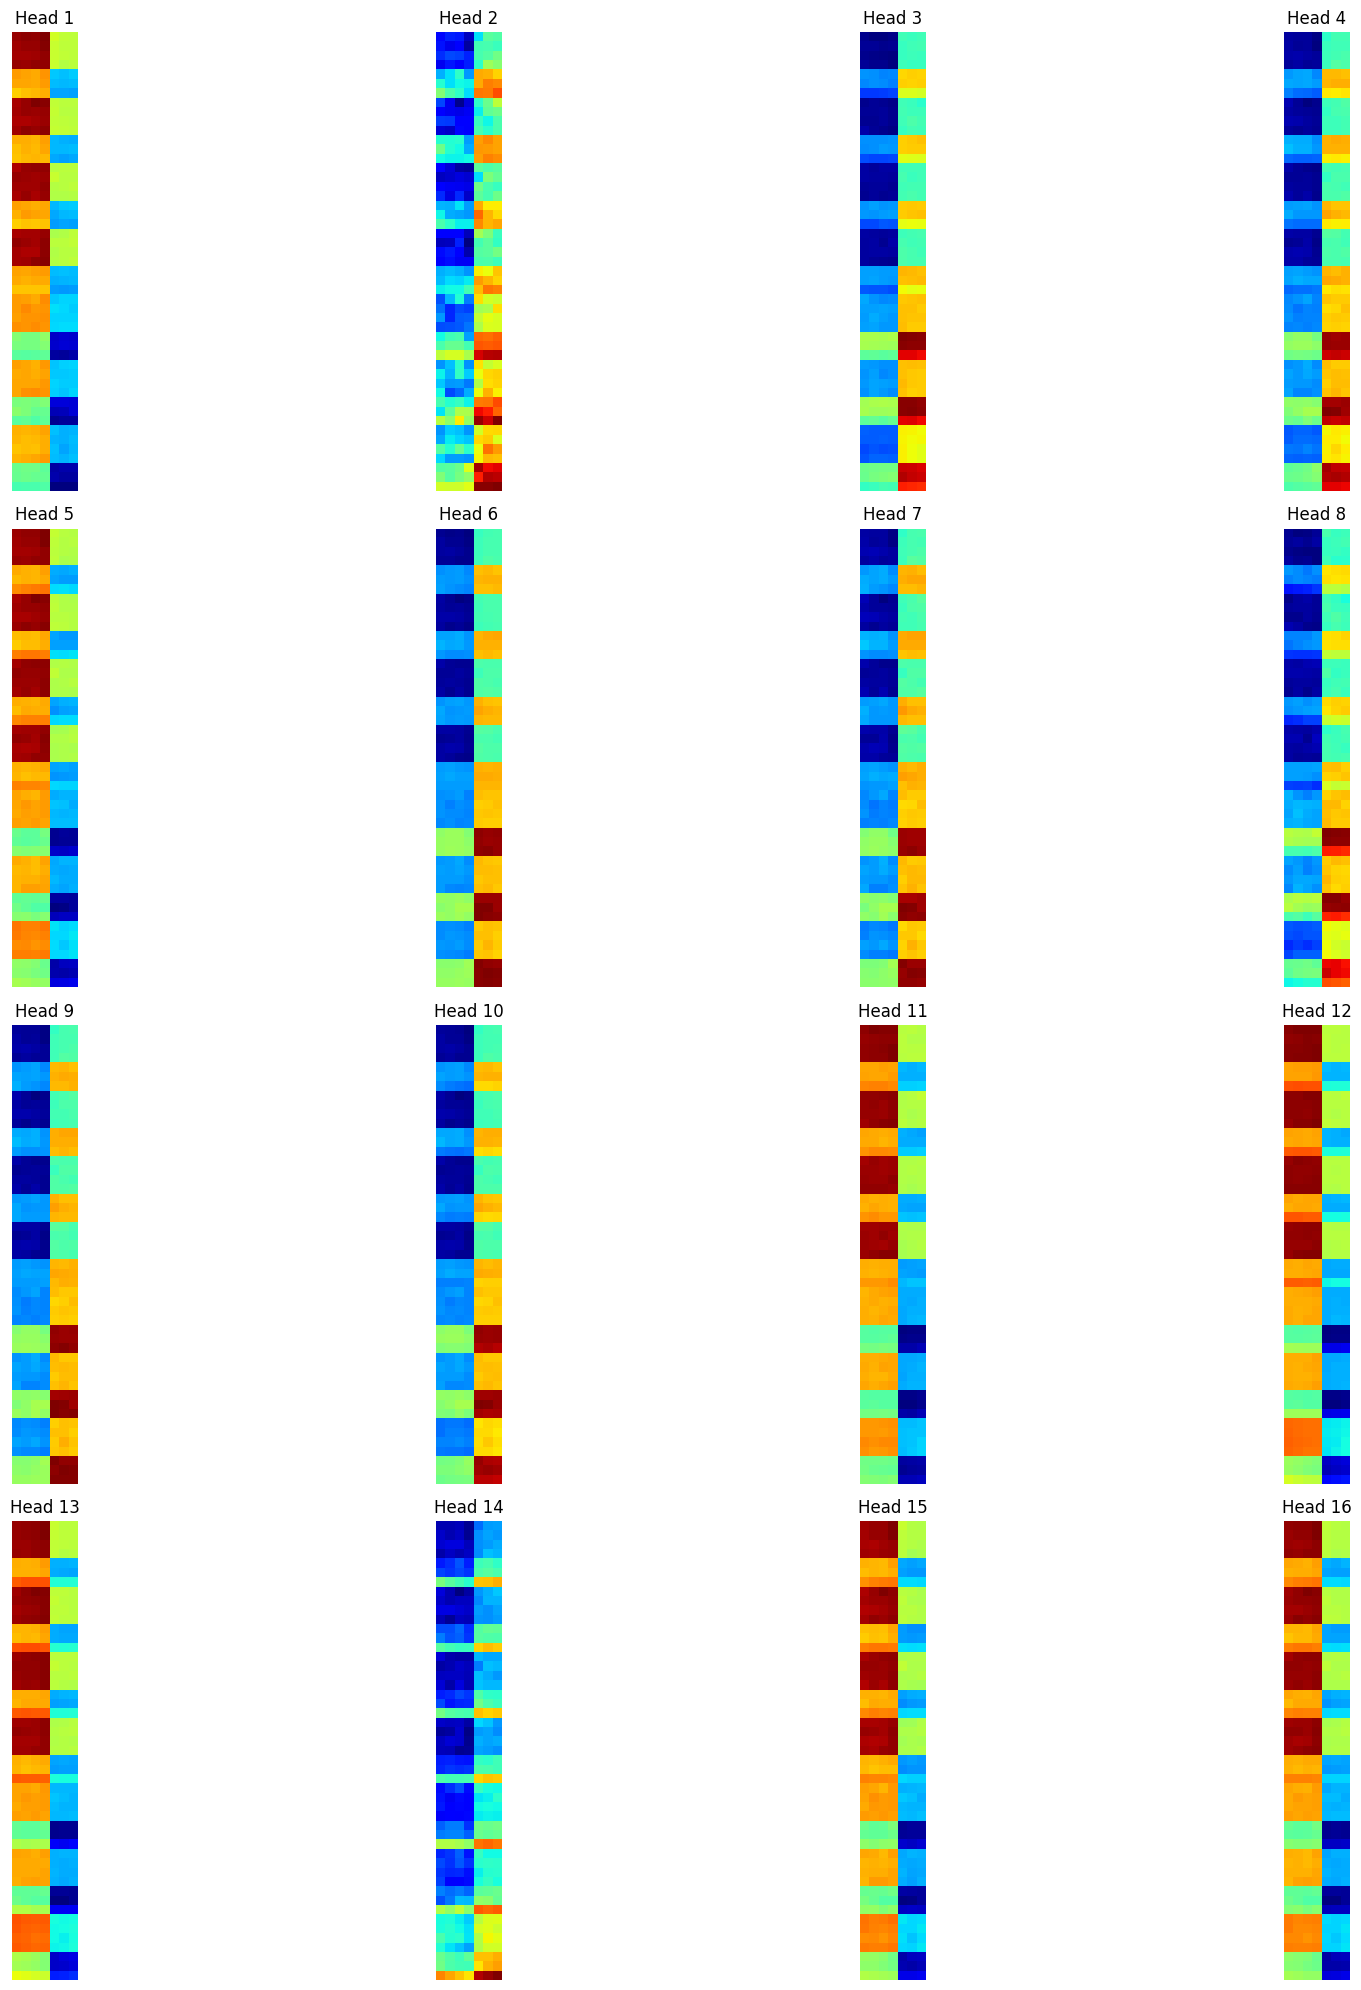

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convert attention tensors to NumPy
last_attention = attentions[-1].detach().cpu().numpy()  # Shape: (4332, 343, 24)

num_heads = min(16, last_attention.shape[2])  # Ensure max 16 heads

# Define a reasonable reshape size (manually adjusted)
height, width = 49, 7  # Try different values if needed

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    if i >= num_heads:
        ax.axis("off")
        continue

    # Extract the attention map for the head
    attn_map = last_attention[:, :, i]  # Shape (4332, 343)
    
    # Average over the first dimension (query tokens)
    attn_map = attn_map.mean(axis=0)  # Now shape (343,)

    # Try reshaping into a rectangular grid
    try:
        attn_map = attn_map.reshape(height, width)
    except ValueError:
        print(f"Skipping head {i}: Cannot reshape {attn_map.shape} into ({height},{width})")
        ax.axis("off")
        continue

    ax.imshow(attn_map, cmap="jet")
    ax.set_title(f"Head {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


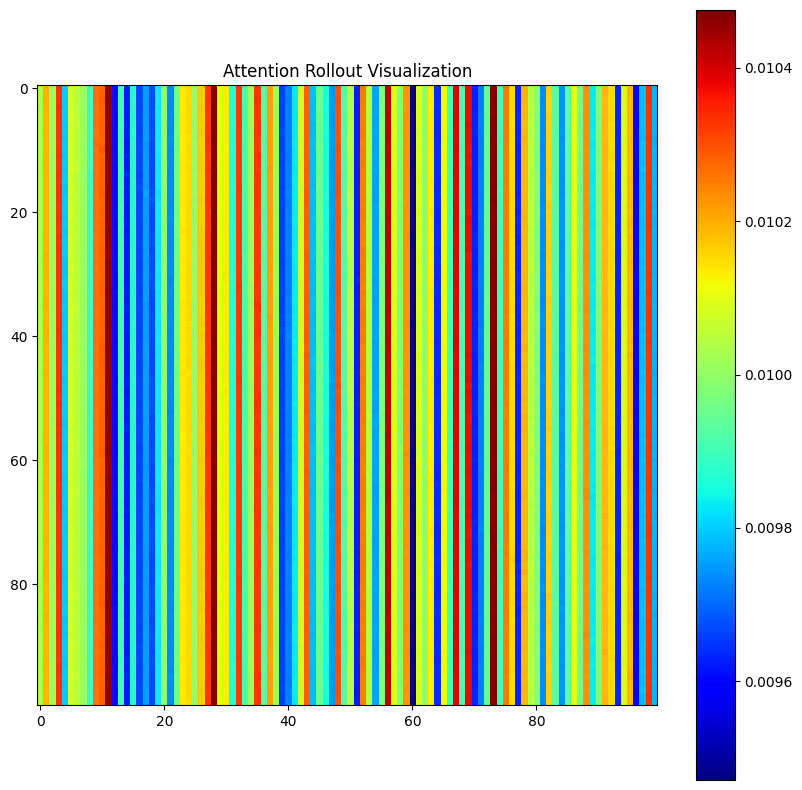

In [30]:
# Simulated attention tensors (assuming 3 layers, 8 heads, 100 tokens)
batch_size, num_layers, num_heads, num_tokens = 1, 3, 8, 100
attentions = [torch.rand(batch_size, num_heads, num_tokens, num_tokens) for _ in range(num_layers)]

# Compute rollout
rollout_attention = attention_rollout(attentions).squeeze(0)  # Shape (num_tokens, num_tokens)

# Convert to NumPy for visualization
rollout_attention_np = rollout_attention.detach().cpu().numpy()

# Plot heatmap
plt.figure(figsize=(10, 10))
plt.imshow(rollout_attention_np, cmap="jet")
plt.colorbar()
plt.title("Attention Rollout Visualization")
plt.show()

Starting compute_rollout
Initial result shape: torch.Size([4332, 24])

Processing attention layer 1
Current result shape: torch.Size([4332, 24])

Processing attention layer 2
Current result shape: torch.Size([4332, 24])

Processing attention layer 3
Current result shape: torch.Size([4332, 24])
Calculated feature size: 65
Error during reshape: shape '[65, 65]' is invalid for input of size 4332
Alternative reshape to: torch.Size([65, 65])


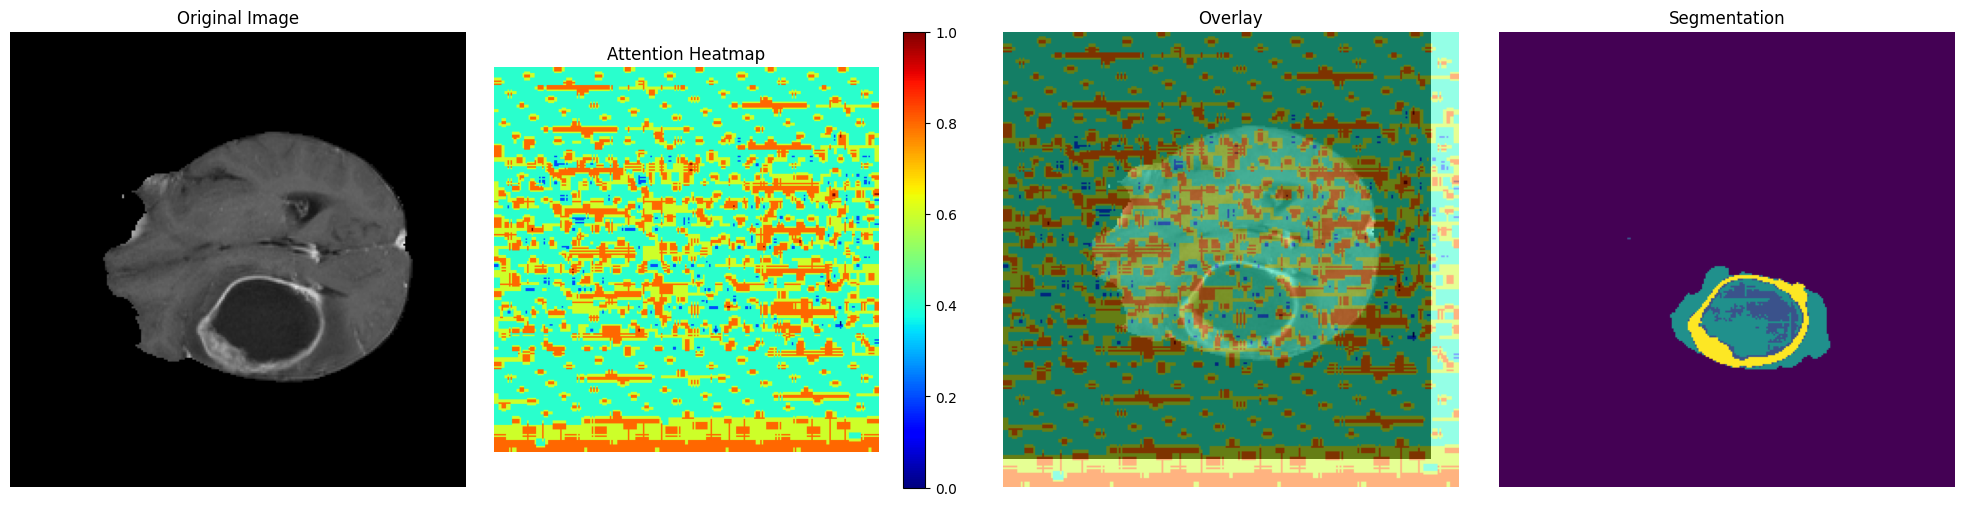

In [24]:
def compute_rollout(attentions):
    """Compute rollout attention maps for SwinUNETR attention structure"""
    print("Starting compute_rollout")
    
    # Initialize result with the first attention map
    first_attn = attentions[0].mean(dim=1)  # Average across heads (343)
    result = first_attn / first_attn.sum(dim=-1, keepdim=True)  # Normalize
    print("Initial result shape:", result.shape)
    
    with torch.no_grad():
        for i, attention in enumerate(attentions[1:], 1):  # Start from second attention
            print(f"\nProcessing attention layer {i}")
            
            # Average across heads and normalize
            attention_mean = attention.mean(dim=1)
            attention_mean = attention_mean / attention_mean.sum(dim=-1, keepdim=True)
            
            # Combine with previous result
            result = attention_mean * result
            
            # Renormalize
            result = result / result.sum(dim=-1, keepdim=True)
            
            print("Current result shape:", result.shape)
    
    # Calculate proper feature size
    # For SwinUNETR with input size 256x256, 4332 patches would be ~66x66
    feat_size = int(np.sqrt(result.shape[0]))
    print(f"Calculated feature size: {feat_size}")
    
    # Reshape to spatial dimensions
    result = result.mean(dim=-1)  # Average across feature dimension
    try:
        result = result.reshape(feat_size, feat_size)
        print(f"Reshaped to: {result.shape}")
    except RuntimeError as e:
        print(f"Error during reshape: {e}")
        # Alternative reshape if needed
        actual_size = int(np.floor(np.sqrt(result.shape[0])))
        result = result[:actual_size**2].reshape(actual_size, actual_size)
        print(f"Alternative reshape to: {result.shape}")
    
    return result

# Process attention maps
rollout = compute_rollout(attention_maps)

# Upsample to original image size
img_size = (256, 256)  # Adjust to your image size
attention_upsampled = torch.nn.functional.interpolate(
    rollout.unsqueeze(0).unsqueeze(0),
    size=img_size,
    mode='bilinear'
).squeeze().cpu().numpy()

# Create the visualization
def create_attention_overlay(image, attention_map, alpha=0.5):
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    plt.figure(figsize=(20, 5))
    
    # Original image
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Attention heatmap
    plt.subplot(1, 4, 2)
    plt.title("Attention Heatmap")
    plt.imshow(attention_map, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 4, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap='gray')
    plt.imshow(attention_map, cmap='jet', alpha=alpha)
    plt.axis('off')
    
    # Segmentation
    plt.subplot(1, 4, 4)
    plt.title("Segmentation")
    plt.imshow(seg_out[:, :, slice_num])
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create the visualization
original_slice = img[:, :, slice_num]
create_attention_overlay(
    image=original_slice,
    attention_map=attention_upsampled,
    alpha=0.5
)
